# John Wales
## 118392816

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#### Tensorflow needed to be installed for these imports to work. Simply copy the line below
- pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom
from tensorflow.keras.layers.experimental.preprocessing import RandomTranslation
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

from tensorflow.keras.models import load_model

from tensorflow.keras.optimizers import SGD

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2

from tensorflow.keras import Model, Input, Sequential

In [3]:
base_dir = ""
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

### An example of what I am comparing. As you can see they are very similar so this would make it difficult to predict. Originally I chose to compare phones with cameras but I found myself producing 100% accuracy. Although that was great I did not particularly like this as it was hard for me to improve the model when the result was the same.

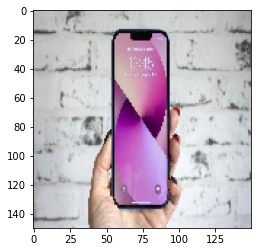

In [4]:
train_iphone_dir = os.path.join(train_dir, "iphone")
filenames = [os.path.join(train_iphone_dir, filename) for filename in os.listdir(train_iphone_dir)]

idx = 1 # Change this if you want to look at a different iphone
some_example = load_img(filenames[idx], target_size=(150,150))

plt.imshow(some_example)

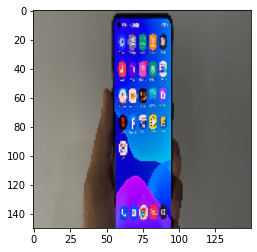

In [5]:
train_androidphone_dir = os.path.join(train_dir, "androidphone")
filenames = [os.path.join(train_androidphone_dir, filename) for filename in os.listdir(train_androidphone_dir)]

idx = 50 # Change this if you want to look at a different android
some_example = load_img(filenames[idx], target_size=(150,150))

plt.imshow(some_example)

In [6]:
train_dataset = image_dataset_from_directory(directory=train_dir, label_mode="binary", image_size=(224, 224))
val_dataset = image_dataset_from_directory(directory=val_dir, label_mode="binary", image_size=(224, 224))
test_dataset = image_dataset_from_directory(directory=test_dir, label_mode="binary", image_size=(224, 224))

Found 100 files belonging to 2 classes.
Found 50 files belonging to 2 classes.
Found 50 files belonging to 2 classes.


2022-02-03 12:49:36.705774: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Pretrained Network ResNet50 for Transfer Learning

In [7]:
resnet50_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Quick note

- As stated in the assignment description, I was required to use **transfer learning** when building all of these models. I did in fact build models that did **not** use transfer learning and found that they were **50%** accurate. I did not include these in this notebook as I thought that there was no need.

# Best Model

- I found this model to be the most effective. I had the lowest overfitting and beating every other model in terms of accuracy. The accuracy ranges between minimum of **82%** and a maximum of **89%**
- This model uses Data Augmentation which increases accuracy by __ % . I discovered that changing the figues for the RandomFlip, RandomRotation and RandomZoom increases overfitting and therefore reducing accuracy.
- Increasing and decreasing the learning rate from 0.01 increases overfitting and reduces accuracy.
- Decreasing the number of layers reduces accuracy although it would reduce the number of parameters. If overfitting is a big problem, reducing the number of layers could help but here there is no need
- x = Dense(1024, activation="relu")(x) increases overfitting and reduces accuracy so instead I use **512**.
- I have discovered that this setup of filters works best. To me this makes the most sense and if you were to represent the neurons on a diagram it would have a diamond shape
- The sigmoid activation function is used at the end here as we are working with Binary Classification. This could be changed if we wanted to use more images, making it multi-class classification.


In [8]:
inputs = Input(shape=(224, 224, 3))
x = RandomFlip(mode="horizontal")(inputs)
x = RandomRotation(factor=0.1)(x)
x = RandomZoom(height_factor=(-0.2, 0.2))(x)
augmentation_layers = RandomTranslation(height_factor=0.2, width_factor=0.2)(x)

x = Rescaling(scale=1./255)(x)
x = Conv2D(filters=16, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=16, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = preprocess_input(inputs)
x = resnet50_base(x)
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
transfer_model = Model(inputs, outputs)
transfer_model.compile(optimizer=SGD(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])

## Changing number of layers and filter size ( number of neurons )

#### It is worth noting that in order for these models to run you need to copy and paste it into the "Best Model". I have done it this way because I did not want to dupliate code

- This model is **70%** accurate

In [9]:
# x = Rescaling(scale=1./255)(x)
# x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=16, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)

- This model is **75%** accurate

In [10]:
# x = Rescaling(scale=1./255)(x)
# x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=16, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)

- This model is **75%** accurate

In [11]:
# x = Rescaling(scale=1./255)(x)
# x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=16, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=8, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)


- This model is **80%** accurate

In [12]:
# x = Rescaling(scale=1./255)(x)
# x = Conv2D(filters=8, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=16, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=16, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=8, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)

### Model without Layers or filters
- This model is **60%** accurate

In [13]:
# inputs = Input(shape=(224, 224, 3))
# x = preprocess_input(inputs)
# x = resnet50_base(x)
# x = Flatten()(x)
# outputs = Dense(1, activation="sigmoid")(x)
# transfer_model = Model(inputs=inputs, outputs=outputs)
# transfer_model.compile(optimizer=SGD(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])

# Changing Data Augmentation

#### It is worth noting that in order for these models to run you need to copy and paste it into the "Best Model". I have done it this way because I did not want to dupliate code

- This model is **78%** accurate

In [14]:
# inputs = Input(shape=(224, 224, 3))
# x = RandomFlip(mode="vertical")(inputs)
# x = RandomRotation(factor=0.5)(x)
# x = RandomZoom(height_factor=(-0.6, 0.6))(x)
# augmentation_layers = RandomTranslation(height_factor=0.6, width_factor=0.6)(x)



- This model is **72%** accurate

In [15]:
# inputs = Input(shape=(224, 224, 3))
# x = RandomFlip(mode="horizontal")(inputs)
# x = RandomRotation(factor=0.2)(x)
# x = RandomZoom(height_factor=(-0.3, 0.3))(x)
# augmentation_layers = RandomTranslation(height_factor=0.3, width_factor=0.3)(x)

- This model is **75%** accurate

In [16]:
# inputs = Input(shape=(224, 224, 3))
# x = RandomFlip(mode="horizontal")(inputs)
# x = RandomRotation(factor=0.8)(x)
# x = RandomZoom(height_factor=(-0.8, 0.8))(x)
# augmentation_layers = RandomTranslation(height_factor=0.8, width_factor=0.8)(x)

# Attempting Dropout

#### It is worth noting that in order for these models to run you need to copy and paste it into the "Best Model". I have done it this way because I did not want to dupliate code

- This model is **80%** accurate
- Here I use 1024 in the Dense layer

In [17]:
# x = Rescaling(scale=1./255)(x)
# x = Dense(1024, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Dense(1024, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Conv2D(filters=16, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=16, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)

- This model is **75%** accurate
- Here I use 512 in the Dense layer and it increases overfitting and reduces accuracy

In [18]:
# x = Rescaling(scale=1./255)(x)
# x = Dense(512, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Conv2D(filters=16, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Conv2D(filters=16, kernel_size=(3, 3), activation="relu")(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)

### Illustrating the numbr of parameters being used. This umber is extremely high due to ResNet50 and the amount of layers that I use. 

In [19]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                             

## Augmented Images
- As seen in the code above, augmented images are flipping, zooming and rotating. I have printed these images to prove that my augmentation works

In [20]:
var = Sequential([RandomFlip(mode="horizontal"),RandomRotation(factor=0.1),RandomZoom(height_factor=(0.2, 0.2))])

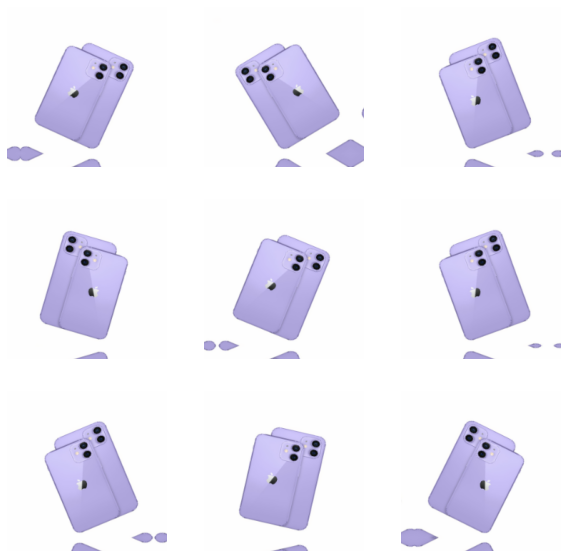

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = var(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### We feeze the weights in the layers of the convolutional base. If we did not, then the features that ResNet50 learned previously would be lost.

In [22]:
for layer in resnet50_base.layers:
    layer.trainable = False

### Setting verbose = 1 removes following error while also providing information on how it is runnning
- I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)transfer_model.compile(optimizer=SGD(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])

### Using early stopping as a way to reduce overfitting. It is important to decide on a patience as this dictates how many times val_loss is allowed to increase before we stop running

In [23]:
transfer_model_history = transfer_model.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=1)

transfer_model_history.history["loss"][-1], transfer_model_history.history["val_loss"][-1]

Epoch 1/30
4/4 [==============================] - 27s 6s/step - loss: 5.5807 - accuracy: 0.4400 - val_loss: 0.5770 - val_accuracy: 0.7400
Epoch 2/30
4/4 [==============================] - 23s 5s/step - loss: 0.2982 - accuracy: 0.9000 - val_loss: 1.0807 - val_accuracy: 0.6000
Epoch 3/30
4/4 [==============================] - 23s 5s/step - loss: 0.1336 - accuracy: 0.9400 - val_loss: 0.4445 - val_accuracy: 0.8200
Epoch 4/30
4/4 [==============================] - 23s 5s/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.3893 - val_accuracy: 0.8000
Epoch 5/30
4/4 [==============================] - 23s 5s/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.3869 - val_accuracy: 0.8000
Epoch 6/30
4/4 [==============================] - 28s 6s/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.3761 - val_accuracy: 0.8000
Epoch 7/30
4/4 [==============================] - 27s 6s/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.3531 - val_accuracy: 0.8000
Epoch 8/30
4/4 [==================

2022-02-03 12:59:47.061004: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 6 of 256
2022-02-03 12:59:47.061081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 7 of 256
2022-02-03 12:59:47.061124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 8 of 256
2022-02-03 12:59:47.061143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 9 of 256
2022-02-03 12:59:47.170286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


4/4 [==============================] - 188s 60s/step - loss: 7.5981e-04 - accuracy: 1.0000 - val_loss: 0.2432 - val_accuracy: 0.8400
Epoch 19/30
4/4 [==============================] - 34s 9s/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.2335 - val_accuracy: 0.8600
Epoch 20/30
4/4 [==============================] - 24s 6s/step - loss: 8.4833e-04 - accuracy: 1.0000 - val_loss: 0.2263 - val_accuracy: 0.8600
Epoch 21/30
4/4 [==============================] - 23s 5s/step - loss: 6.1162e-04 - accuracy: 1.0000 - val_loss: 0.2205 - val_accuracy: 0.8600
Epoch 22/30
4/4 [==============================] - 23s 5s/step - loss: 5.9906e-04 - accuracy: 1.0000 - val_loss: 0.2153 - val_accuracy: 0.8800
Epoch 23/30
4/4 [==============================] - 23s 5s/step - loss: 7.6544e-04 - accuracy: 1.0000 - val_loss: 0.2135 - val_accuracy: 0.9000
Epoch 24/30
4/4 [==============================] - 23s 5s/step - loss: 6.9846e-04 - accuracy: 1.0000 - val_loss: 0.2145 - val_accuracy: 0.9000
Epoch 25/30
4

(0.00037080899346619844, 0.22430847585201263)

### Here I am showing the difference between loss and val_loss
- If early stopping occurs you can see precisely where it has happened

In [24]:
[(l, v) for l, v in zip(transfer_model_history.history["loss"], transfer_model_history.history["val_loss"])]

[(5.5807037353515625, 0.576984167098999),
 (0.29822954535484314, 1.0806549787521362),
 (0.13364380598068237, 0.44445326924324036),
 (0.006684478372335434, 0.38934600353240967),
 (0.0038744457997381687, 0.38693296909332275),
 (0.0022378102876245975, 0.3760946989059448),
 (0.0023003709502518177, 0.35308003425598145),
 (0.002242482267320156, 0.3381970226764679),
 (0.0017193749081343412, 0.328724205493927),
 (0.002305389614775777, 0.3223516345024109),
 (0.0014534672955051064, 0.29998618364334106),
 (0.0015702256932854652, 0.2831111252307892),
 (0.0012680895160883665, 0.27721962332725525),
 (0.0009171286947093904, 0.2689827084541321),
 (0.003314431058242917, 0.2782486379146576),
 (0.002116220770403743, 0.2619759440422058),
 (0.0012404251610860229, 0.24957828223705292),
 (0.0007598054362460971, 0.24320711195468903),
 (0.0010489891283214092, 0.23346255719661713),
 (0.0008483334677293897, 0.22633694112300873),
 (0.000611616880632937, 0.2204810380935669),
 (0.0005990597419440746, 0.215252652764

### This graph shows that my model is overfitting but is not a major problem

<AxesSubplot:>

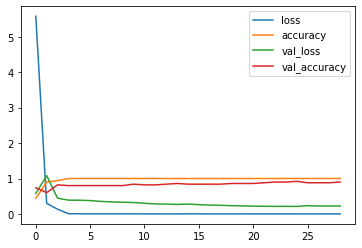

In [25]:
pd.DataFrame(transfer_model_history.history).plot()

### Unfreezing the weights Now that our new top layesr are well-trained, we can unfreeze all layers in the base (or just the top ones in the base) and contnue training.

In [26]:
for layer in resnet50_base.layers:
    layer.trainable = True

### Just showing that the parameters have not changed

In [27]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                             

### Recompiling but not building a new model.  The whole idea is to continue to tune the one we've already built.)
### Lowering the learning rate to avoid damaging the pretrained weights.


In [28]:
transfer_model.compile(optimizer=SGD(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

### Resuming training. Again setting verbose to 1 so there is no error and also to check the progress of the training
- As you can see, freezing and unfreezing the weights have helped here with **overfitting**

In [29]:
transfer_model_history = transfer_model.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=1)

transfer_model_history.history["loss"][-1], transfer_model_history.history["val_loss"][-1]


Epoch 1/30
4/4 [==============================] - 30s 6s/step - loss: 6.3813e-04 - accuracy: 1.0000 - val_loss: 0.2096 - val_accuracy: 0.9200
Epoch 2/30
4/4 [==============================] - 25s 6s/step - loss: 5.8748e-04 - accuracy: 1.0000 - val_loss: 0.2088 - val_accuracy: 0.9200
Epoch 3/30
4/4 [==============================] - 24s 6s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.2079 - val_accuracy: 0.9200
Epoch 4/30
4/4 [==============================] - 23s 5s/step - loss: 3.2409e-04 - accuracy: 1.0000 - val_loss: 0.2068 - val_accuracy: 0.9000
Epoch 5/30
4/4 [==============================] - 26s 6s/step - loss: 3.1251e-04 - accuracy: 1.0000 - val_loss: 0.2061 - val_accuracy: 0.9000
Epoch 6/30
4/4 [==============================] - 26s 6s/step - loss: 2.9511e-04 - accuracy: 1.0000 - val_loss: 0.2064 - val_accuracy: 0.9000
Epoch 7/30
4/4 [==============================] - 28s 6s/step - loss: 5.3465e-04 - accuracy: 1.0000 - val_loss: 0.2062 - val_accuracy: 0.9000
Epoch 8/30

(0.0007395991124212742, 0.20120757818222046)

### Same as before. I am again showing the difference between loss and val_loss and demonstrating early stopping

In [30]:
[(l, v) for l, v in zip(transfer_model_history.history["loss"], transfer_model_history.history["val_loss"])]

[(0.0006381331477314234, 0.20956763625144958),
 (0.0005874824710190296, 0.20883087813854218),
 (0.001520145102404058, 0.20791304111480713),
 (0.00032409236882813275, 0.20679928362369537),
 (0.0003125147777609527, 0.20609064400196075),
 (0.0002951074275188148, 0.2064078450202942),
 (0.0005346463294699788, 0.2062150239944458),
 (0.0008523277938365936, 0.2054145634174347),
 (0.000459020200651139, 0.20545536279678345),
 (0.0002768314443528652, 0.2047373354434967),
 (0.0004254432278685272, 0.20451870560646057),
 (0.000671100162435323, 0.20496442914009094),
 (0.00047995991189964116, 0.20451313257217407),
 (0.0004826099902857095, 0.2039289027452469),
 (0.000321286846883595, 0.20447289943695068),
 (0.0004024040244985372, 0.20326687395572662),
 (0.000376137817511335, 0.20136259496212006),
 (0.0003766455629374832, 0.20046593248844147),
 (0.00125788152217865, 0.20223365724086761),
 (0.00029370770789682865, 0.2016783505678177),
 (0.0004369310918264091, 0.20113372802734375),
 (0.0007395991124212742

<AxesSubplot:>

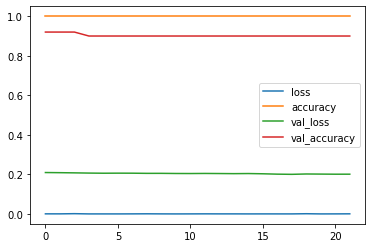

In [31]:
pd.DataFrame(transfer_model_history.history).plot()

# Testing
- The convnet that was trained and tuned using transfer learning ( Best Model )



In [32]:
test_loss, test_acc = transfer_model.evaluate(test_dataset)
test_acc

2/2 [==============================] - 3s 979ms/step - loss: 0.5698 - accuracy: 0.8600


0.8600000143051147

### Saving the model so it can be used in another notebook

In [34]:
transfer_model.save("best_network.h5")

/Users/johnwales/opt/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
